In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib notebook

In [26]:
freeFloats = pd.read_csv(r'extraCompanyDataFinal/freeFloatBuffered.csv')
sharesOutstanding = pd.read_csv(r'extraCompanyDataFinal/outSharesBuffered.csv')

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 15, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
FTSE

,Unnamed: 0,Open,High,Low,Close,Volume,Date,Day,Year
114,114,7419.3999,7479.0000,7419.3999,7463.5000,1889237700,2017-06-16,167,2017
115,115,7463.5000,7537.7998,7463.5000,7523.7998,551165300,2017-06-19,170,2017
116,116,7523.7998,7561.1001,7472.7002,7472.7002,1005340300,2017-06-20,171,2017
117,117,7472.7002,7477.2002,7417.5000,7447.7998,843652400,2017-06-21,172,2017
118,118,7447.7998,7448.5000,7398.7998,7439.2998,789287000,2017-06-22,173,2017
...,...,...,...,...,...,...,...,...,...
753,753,7582.5000,7628.2002,7559.6001,7623.6001,539145700,2019-12-23,357,2019
754,754,7623.6001,7636.2002,7608.2002,7632.2002,185671600,2019-12-24,358,2019
755,755,7632.2002,7665.3999,7622.5000,7644.8999,311117100,2019-12-27,361,2019
756,756,7644.8999,7644.8999,7587.1001,7587.1001,304247900,2019-12-30,364,2019


In [27]:
#freeFloats['AAL'][0]
#print(freeFloats.head())
#print(sharesOutstanding.head())
#print(FTSEStocksEachQuarter.head())
#FTSE.head()

In [28]:
#dates for share close prices between any two quarters - for index divisor
quarterCutOffDates = [datetime.strptime('Jun 16, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 15, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 15, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 16, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 15, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 21, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 21, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 15, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 21, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 20, 2019', '%b %d, %Y').date()
                        ]
quarterCutOffDates = [datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3, 17','Q4, 17', 'Q1, 18', 'Q2, 18', 'Q3, 18', 'Q4, 18', 'Q1, 19', 'Q2, 19', 'Q3, 19', 'Q4, 19']

#quarterCutOffDates.appenddatetime.strptime('Jun 19, 2017', '%b %d, %Y').date(),
quarterCutOffDates.reverse()
quarterNames.reverse()

len(quarterNames)
quarterNames[0][0:2]
quarterCutOffDates

[datetime.date(2019, 9, 23),
 datetime.date(2019, 6, 24),
 datetime.date(2019, 3, 18),
 datetime.date(2018, 12, 24),
 datetime.date(2018, 9, 24),
 datetime.date(2018, 6, 18),
 datetime.date(2018, 3, 19),
 datetime.date(2017, 12, 18),
 datetime.date(2017, 9, 18),
 datetime.date(2017, 6, 19)]

In [29]:
indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates}, index = quarterNames)
indexDivisors

,Quarter CO Date
"Q4, 19",2019-09-23
"Q3, 19",2019-06-24
"Q2, 19",2019-03-18
"Q1, 19",2018-12-24
"Q4, 18",2018-09-24
"Q3, 18",2018-06-18
"Q2, 18",2018-03-19
"Q1, 18",2017-12-18
"Q4, 17",2017-09-18
"Q3, 17",2017-06-19


In [30]:
indexDivisorsList = []

for idx, quarter in enumerate(indexDivisors.index.values):
    sumOfMarketCaps = 0
    listOfMCs = []
    for stock in FTSEStocksEachQuarter[quarter].values:
        
        if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
        else:
            stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
        stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
        #print(stock)
        #print(type(stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0]))
        #print(stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0])
        try:
            marketCap = freeFloats[stock][idx]*sharesOutstanding[stock][idx]*stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0]
            marketCap = marketCap/100
        except IndexError:
            print('exception: ', stock)
            continue
        listOfMCs.append([stock, marketCap])
        #print(quarter)
        sumOfMarketCaps +=marketCap
        
        price = stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0]
        #print(f'Quarter = {quarter}, Stock = {stock}, Free Float = {freeFloats[stock][idx]}, SO = {sharesOutstanding[stock][idx]}, Price = {price}, Market Cap = {marketCap}')

    print(quarter,sumOfMarketCaps , (FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0]))
    indexDivisorsList.append(sumOfMarketCaps/(FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0])) 
    
indexDivisors['Divisors'] = indexDivisorsList    
#indexDivisors.to_csv('indexDivisors.csv')
indexDivisors

Q4, 19 2031736529094.341 7326.1001
Q3, 19 2074224378700.6628 7416.7002
Q2, 19 2172786815906.6882 7299.2002
Q1, 19 2008567963484.364 6686.0
Q4, 18 2089058413591.9932 7458.3999
Q3, 18 2133811887306.8447 7631.2998
Q2, 18 1935028818020.289 7042.8999
Q1, 18 2076146123631.1765 7537.0
Q4, 17 1967107641638.019 7253.2998
Q3, 17 2000667629197.8477 7523.7998


,Quarter CO Date,Divisors
"Q4, 19",2019-09-23,2.773285e+08
"Q3, 19",2019-06-24,2.796694e+08
"Q2, 19",2019-03-18,2.976746e+08
"Q1, 19",2018-12-24,3.004140e+08
"Q4, 18",2018-09-24,2.800947e+08
"Q3, 18",2018-06-18,2.796132e+08
"Q2, 18",2018-03-19,2.747489e+08
"Q1, 18",2017-12-18,2.754605e+08
"Q4, 17",2017-09-18,2.712018e+08
"Q3, 17",2017-06-19,2.659119e+08


In [31]:
FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date']['2018-06-15']]['Close'].values[0]
#(0.966*1117*973004394)/100

KeyError: '2018-06-15'

In [32]:
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.insert(0,datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())


In [47]:
for idx, quarter in enumerate(indexDivisors.index.values):
    index = FTSE[(FTSE['Date'] <= quarterCutOffDates[idx]) & (FTSE['Date'] >= quarterCutOffDates[idx+1])].Date.values
    #print(index)
    stockMarketCapsEachQuarter = pd.DataFrame(columns = FTSEStocksEachQuarter[quarter].values, index = index)
    sumOfMarketCaps= 0
    listOfMCs =[]
    for stock in FTSEStocksEachQuarter[quarter].values:
        
        if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
        else:
            stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
        stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
        
        stockAdjMarkCaps = stockPrice[(stockPrice['Date'] <= quarterCutOffDates[idx]) & (stockPrice['Date'] >= quarterCutOffDates[idx+1])]['Open']
        stockAdjMarkCaps = stockAdjMarkCaps.multiply(sharesOutstanding[stock][idx])
        stockAdjMarkCaps = stockAdjMarkCaps.multiply(freeFloats[stock][idx])
        
        stockAdjMarkCaps = stockAdjMarkCaps.divide(100)
        stockAdjMarkCaps = stockAdjMarkCaps.to_frame()
        stockAdjMarkCaps = stockAdjMarkCaps.set_index(index)
        
        stockMarketCapsEachQuarter[stock]=stockAdjMarkCaps
         
        #try:
        marketCap = (freeFloats[stock][idx]*sharesOutstanding[stock][idx]*stockPrice[stockPrice['Date'] == quarterCutOffDates[idx+1]]['Open'].values[0])/100
        #print('Market Cap on :',index[0], ' = ', stockAdjMarkCaps['Open'][0], '\n Market Cap on ', quarterCutOffDates[idx+1], ' = ',marketCap)
        #print('stock price 1',stockPrice[(stockPrice['Date'] <= quarterCutOffDates[idx]) & (stockPrice['Date'] >= quarterCutOffDates[idx+1])]['Open'],'price 2 ', stockPrice[stockPrice['Date'] == quarterCutOffDates[idx+1]]['Open'])
        marketCap = marketCap/100
        #except IndexError:
            #print('exception: ', stock)
            #continue
        listOfMCs.append([stock, marketCap])
        sumOfMarketCaps +=marketCap
        
    #print(stockMarketCapsEachQuarter) 
    totalMarketCap = stockMarketCapsEachQuarter.sum(axis=1)
    #print(index[0], totalMarketCap[0],FTSEPriceQuarterly[0])
    indexDivisorForQuarter = sumOfMarketCaps/(FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0])
    
    indexDivisorsList.append(indexDivisorForQuarter)
    FTSEPriceQuarterly = totalMarketCap.divide(indexDivisorForQuarter)
    FTSEPriceQuarterly = FTSEPriceQuarterly.divide(100)
    #print(FTSEPriceQuarterly)
    if idx == 0:
        FTSEPrice3yr = FTSEPriceQuarterly
        print('new')
    else:
        FTSEPrice3yr = FTSEPriceQuarterly.append(FTSEPrice3yr)
        print('add')
    #print(quarter,sumOfMarketCaps , (FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0]),'\n')
    
indexDivisors['Divisors'] = indexDivisorsList
    #print(totalMarketCap)
    #quarterlyStockPrices = quarterlyStockPrices.div(indexDivisors['Divisors'][idx])
    #print('qsp div',quarterlyStockPrices)
    #closePriceDF = pd.concat([closePriceDF, quarterlyStockPrices])
    #print('cp',closePriceDF)
#print(stockMarketCapsEachQuarter) 
print(FTSEPrice3yr)
#closePrice
#simulatedFTSE['Close'] = closePriceDF
#simulatedFTSE

new
add
add
add
add
add
add
add
add
add


ValueError: Length of values does not match length of index

In [48]:
#stockAdjMarkCaps[0]
10428437303.88138 
10442536137.55044
FTSEPrice3yr

2017-06-19    7463.500000
2017-06-20    7482.118071
2017-06-21    7410.726705
2017-06-22    7372.946978
2017-06-23    7350.758979
                 ...     
2019-12-17    7394.319912
2019-12-18    7414.633761
2019-12-19    7454.295263
2019-12-20    7481.855615
2019-12-23    7472.903519
Length: 648, dtype: float64

In [95]:
listOfMCs
#quarterCutOffDates

[['III', 8460009003.147521],
 ['ABF', 10350585770.7969],
 ['ADM', 3850620357.14769],
 ['AAL', 12888562955.399391],
 ['ANTO', 2664228100.810375],
 ['AHT', 7822128052.98624],
 ['AZN', 67365292458.3936],
 ['AUTO', 3681144573.0634084],
 ['AV.', 21672522019.54656],
 ['BA.', 21435985326.594135],
 ['BARC', 35069081450.52723],
 ['BDEV', 5590203671.459439],
 ['BHP', 24786882944.95455],
 ['BP', 92254564144.43338],
 ['BATS', 98912053751.87541],
 ['BLND', 6433264407.76677],
 ['BT-A', 24147907353.653],
 ['BNZL', 7804172462.934541],
 ['BRBY', 7421460141.278041],
 ['CCL', 8305865436.705899],
 ['CNA', 11100224090.3931],
 ['CCH', 4351768769.55744],
 ['CPG', 28399593021.600784],
 ['CRH', 23946933732.04332],
 ['CRDA', 5285585508.571922],
 ['DCC', 6285373998.5202],
 ['DGE', 59414343611.88964],
 ['DLG', 4968823750.0],
 ['EVR', 568132758.501568],
 ['EZJ', 3498994527.35301],
 ['EXPN', 15192391063.116],
 ['FERG', 12935031027.652107],
 ['FLTR', 6668397916.765751],
 ['FRES', 2818352696.23296],
 ['GSK', 82374566

<IPython.core.display.Javascript object>


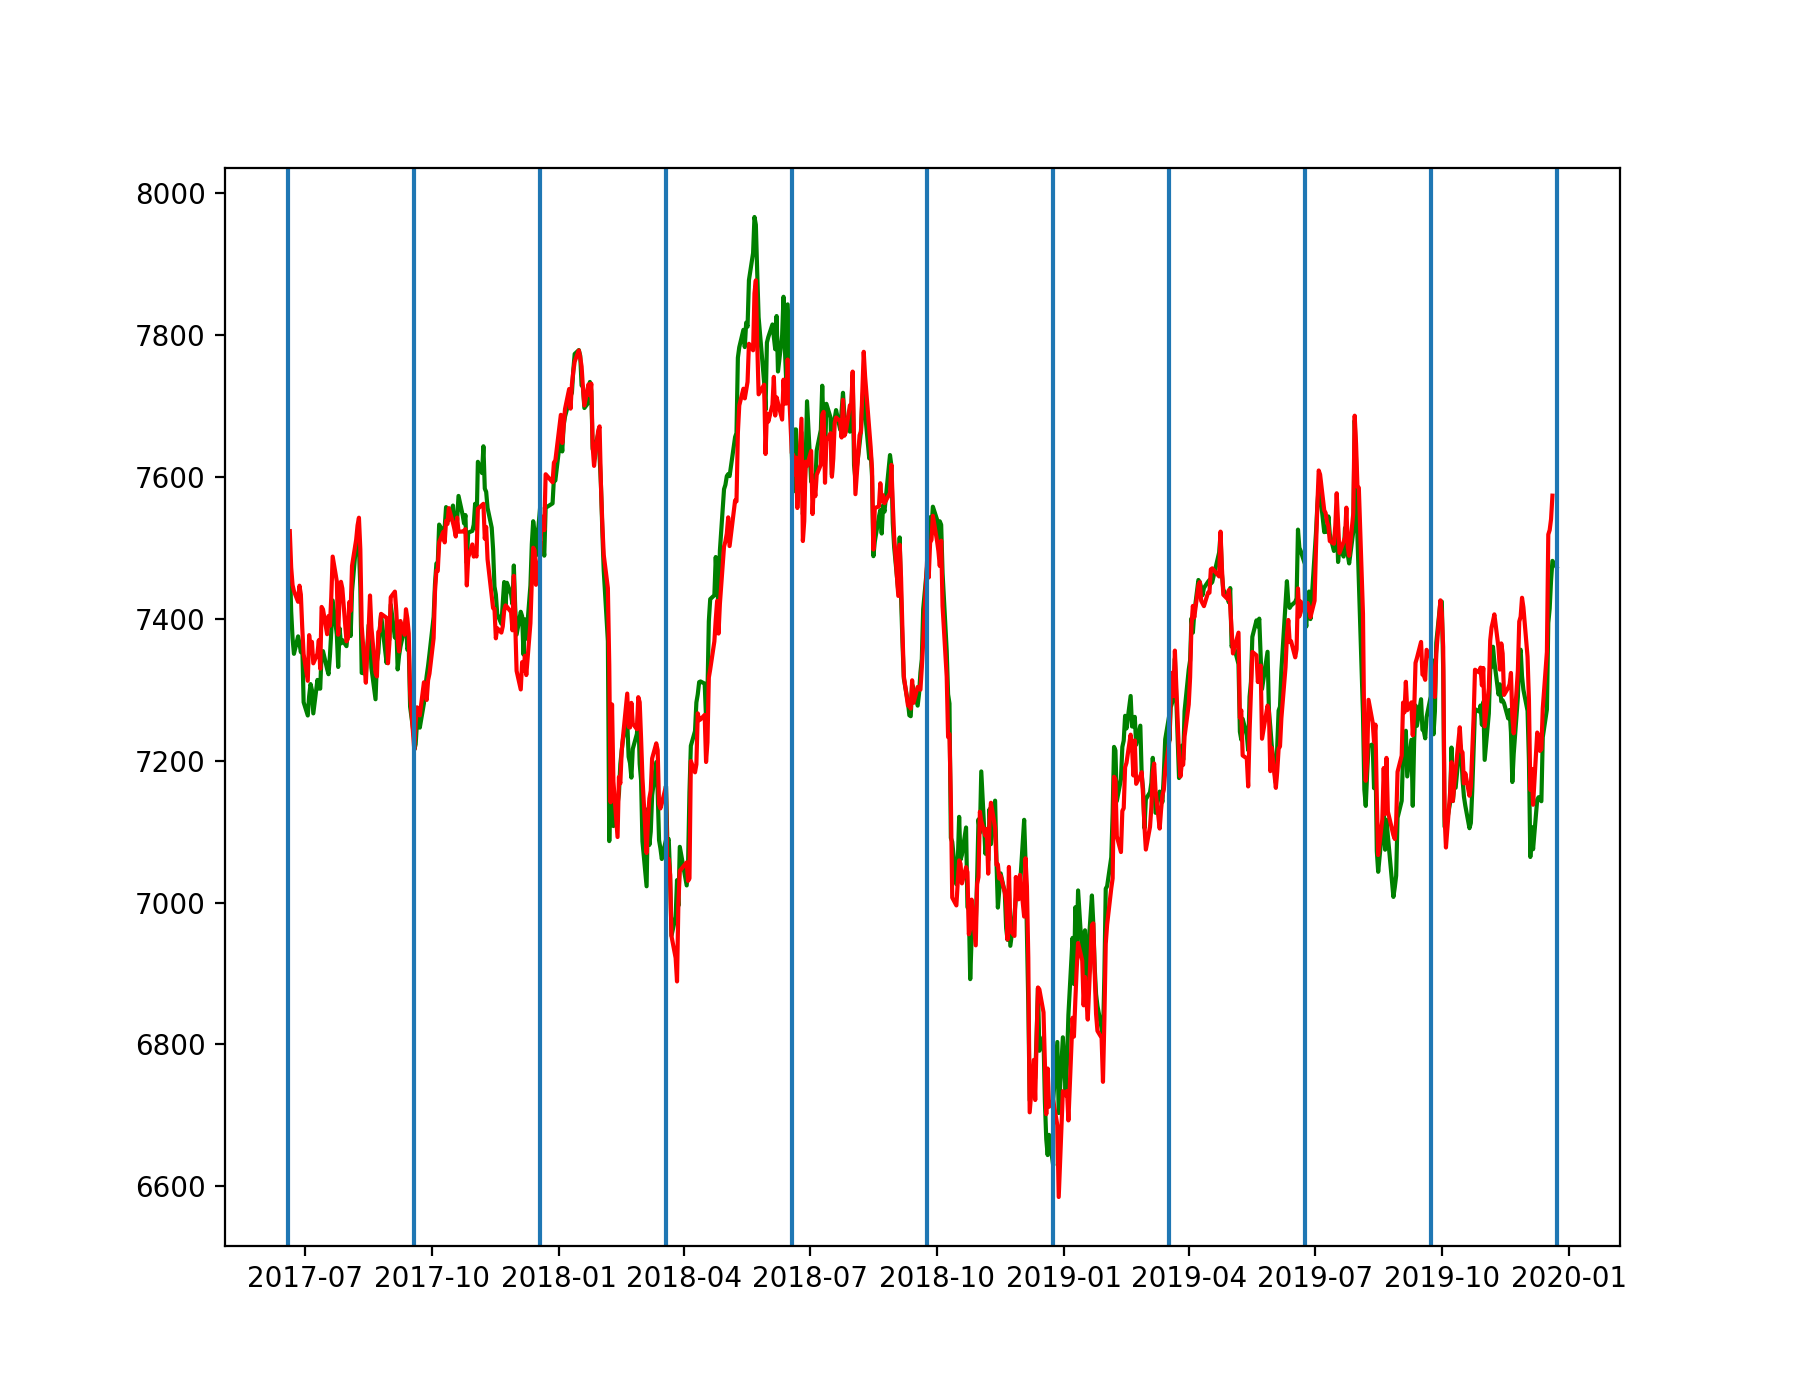

In [52]:
FTSEq317 = FTSE[(FTSE['Date'] < quarterCutOffDates[0]) & (FTSE['Date'] > quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] < quarterCutOffDates[0]) & (FTSE['Date'] > quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(FTSEPrice3yr.index.values,FTSEPrice3yr.values,'g')
axs.plot(FTSEq317date,FTSEq317,'r')
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
#axs.show()

In [18]:
stockPrice = pd.read_csv('stockCSVs/MNG.L17-20.csv')
stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
stockPrice[(stockPrice['Date'] < quarterCutOffDates[0]) & (stockPrice['Date'] > quarterCutOffDates[0+1])]['Close']
#stockPrice[(stockPrice['Date'] > quarterCutOffDates[1])]
#stockPrice.iloc[510]
#type(stockPrice['Date'].values[0])# 
quarterCutOffDates[1:]


[datetime.date(2019, 9, 23),
 datetime.date(2019, 6, 24),
 datetime.date(2019, 3, 18),
 datetime.date(2018, 12, 24),
 datetime.date(2018, 9, 24),
 datetime.date(2018, 6, 18),
 datetime.date(2018, 3, 19),
 datetime.date(2017, 12, 18),
 datetime.date(2017, 9, 18),
 datetime.date(2017, 6, 19)]

In [96]:
quarterCutOffDates = [datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date()
                        ]
quarterCutOffDates.reverse()
indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates}, index = quarterNames)
indexDivisorsList = []
for idx, quarter in enumerate(indexDivisors.index.values):
    sumOfMarketCaps = 0
    listOfMCs =[]
    for stock in FTSEStocksEachQuarter[quarter].values:
        
        if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
        else:
            stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
        stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
        #print(stock)
        #print(type(stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0]))
        #print(stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Close'].values[0])
        try:
            marketCap = freeFloats[stock][idx]*sharesOutstanding[stock][idx]*stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0]
            marketCap = marketCap/100
        except IndexError:
            print('exception: ', stock)
            continue
        listOfMCs.append([stock, marketCap])
        sumOfMarketCaps +=marketCap
        
        #price = stockPrice[stockPrice['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0]
        #print(f'Quarter = {quarter}, Stock = {stock}, Free Float = {freeFloats[stock][idx]}, SO = {sharesOutstanding[stock][idx]}, Price = {price}, Market Cap = {marketCap}')

    print(quarter,sumOfMarketCaps , (FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0]))
    indexDivisorsList.append(sumOfMarketCaps/(FTSE[FTSE['Date'] == indexDivisors['Quarter CO Date'][quarter]]['Open'].values[0])) 
    
indexDivisors['Divisors'] = indexDivisorsList    
#indexDivisors.to_csv('indexDivisors.csv')
indexDivisors
#2037895277951.3208
2002980706885.245

Q4, 19 2038910414654.1577 7344.8999
Q3, 19 2070009593463.2017 7407.5
Q2, 19 2155906926751.491 7228.2998
Q1, 19 1998119733134.2646 6721.2002
Q4, 18 2089827163751.332 7490.2002
Q3, 18 2130856216906.1216 7633.8999
Q2, 18 1963819764553.431 7164.1001
Q1, 18 2071119277546.5793 7490.6001
Q4, 17 1964554344432.5444 7215.5
Q3, 17 1997996605135.732 7463.5


,Quarter CO Date,Divisors
"Q4, 19",2019-09-23,2.775954e+08
"Q3, 19",2019-06-24,2.794478e+08
"Q2, 19",2019-03-18,2.982592e+08
"Q1, 19",2018-12-24,2.972862e+08
"Q4, 18",2018-09-24,2.790082e+08
"Q3, 18",2018-06-18,2.791308e+08
"Q2, 18",2018-03-19,2.741195e+08
"Q1, 18",2017-12-18,2.764958e+08
"Q4, 17",2017-09-18,2.722686e+08
"Q3, 17",2017-06-19,2.677024e+08


In [ ]:
#Q4, 19 2034955940724.4534 7344.8999
#2019-09-23    2.038910e+12